# Iteration 6: Full-dataset for classification competition

## Modules

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
clone = sklearn.clone
sklearn.set_config(transform_output='pandas')

## Import data

In [2]:
raw_df = pd.read_csv('../data/housing_iteration_6_competition/housing-classification-iter6.csv', index_col='Id')
raw_df

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,8450,65.0,856,3,0,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,9600,80.0,1262,3,1,0,2,298,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,11250,68.0,920,3,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,9550,60.0,756,3,1,0,3,0,0,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,14260,84.0,1145,4,1,0,3,192,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,7917,62.0,953,3,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,13175,85.0,1542,3,2,0,2,349,0,0,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,9042,66.0,1152,4,2,0,1,0,0,1,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


Split off labels:

In [3]:
X = raw_df.copy()
y = X.pop('Expensive')

Split into training vs. test set:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
len(X_train), len(X_test), len(y_train), len(y_test)

(1314, 146, 1314, 146)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 1141 to 817
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1314 non-null   int64  
 1   LotFrontage    1085 non-null   float64
 2   TotalBsmtSF    1314 non-null   int64  
 3   BedroomAbvGr   1314 non-null   int64  
 4   Fireplaces     1314 non-null   int64  
 5   PoolArea       1314 non-null   int64  
 6   GarageCars     1314 non-null   int64  
 7   WoodDeckSF     1314 non-null   int64  
 8   ScreenPorch    1314 non-null   int64  
 9   MSZoning       1314 non-null   object 
 10  Condition1     1314 non-null   object 
 11  Heating        1314 non-null   object 
 12  Street         1314 non-null   object 
 13  CentralAir     1314 non-null   object 
 14  Foundation     1314 non-null   object 
 15  ExterQual      1314 non-null   object 
 16  ExterCond      1314 non-null   object 
 17  BsmtQual       1281 non-null   object 
 18  BsmtCond   

Many columns have has some missing rows.

## Handle data types (numerical/nominal/ordinal)

In [6]:
cat_columns = X.select_dtypes(exclude=['number']).columns
cat_columns

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtFinType2',
       'HeatingQC', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [34]:
ord_columns = {
        'ExterQual': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'ExterCond': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'BsmtQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'BsmtCond': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'BsmtExposure': [ 'Gd', 'Av', 'NA', 'Mn', 'No' ],
        'BsmtFinType1': [ 'GLQ', 'ALQ', 'NA', 'BLQ', 'Rec', 'LwQ', 'Unf' ],
        'BsmtFinType2': [ 'GLQ', 'ALQ', 'NA', 'BLQ', 'Rec', 'LwQ', 'Unf' ],
        'KitchenQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'FireplaceQu': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'LotShape': [ 'Reg', 'IR1', 'IR2', 'IR3' ],
        'Utilities': [ 'AllPub', 'NA', 'NoSewr', 'NoSeWa', 'ELO' ],
        'LandSlope': [ 'Gtl', 'Mod', 'Sev' ],
        'HeatingQC': [ 'Ex', 'Gd', 'TA', 'Fa', 'Po' ],
        'Electrical': [ 'SBrkr', 'FuseA', 'Mix', 'FuseF', 'FuseP', 'NA' ],
        'Functional': [ 'Typ', 'NA', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal' ],
        'GarageFinish': [ 'Fin', 'NA', 'RFn', 'Unf' ],
        'GarageQual': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'GarageCond': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa', 'Po' ],
        'PoolQC': [ 'Ex', 'Gd', 'TA', 'NA', 'Fa' ],
        'Fence': [ 'GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'NA' ], # review order, experiment?
}

In [35]:
nom_columns = cat_columns.drop(list(ord_columns.keys()))
nom_columns

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'GarageType', 'PavedDrive',
       'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [36]:
num_columns = X.select_dtypes(include=['number']).columns
num_columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'MiscVal', 'MoSold',
       'YrSold'],
      dtype='object')

### Ordinal encoder

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_pipe = make_pipeline(
  SimpleImputer(strategy='constant', fill_value='NA'),
  ColumnTransformer(transformers=[
    (col,
     OrdinalEncoder(categories = [list(reversed(values))]), #, handle_unknown='use_encoded_value', unknown_value=-1),
     [col])
    for col, values in ord_columns.items()
  ])
)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('columntransformer',
                 ColumnTransformer(transformers=[('ExterQual',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['ExterQual']),
                                                 ('ExterCond',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['ExterCond']),
                                                 ('BsmtQual',
                                                  OrdinalEncoder(categories=[['Po'...
                                                 ('GarageQual',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'NA',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['GarageQual']),
                                                 ('GarageCond',
                                                  OrdinalEncoder(categories=[['Po',
                                                                              'Fa',
                                                                              'NA',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['GarageCond']),
                                                 ('PoolQC',
                                                  OrdinalEncoder(categories=[['Fa',
                                                                              'NA',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex']]),
                                                  ['PoolQC']),
                                                 ('Fence',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'MnWw',
                                                                              'MnPrv',
                                                                              'GdWo',
                                                                              'GdPrv']]),
                                                  ['Fence'])]))])

### Nominal encoder

In [38]:
nom_pipe = make_pipeline(
  SimpleImputer(strategy='constant', fill_value='unknown'),
  OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'),
)
nom_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='unknown', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                               sparse_output=False))])

### Numerical preprocessor

In [39]:
num_pipe = make_pipeline(
  SimpleImputer(strategy='mean')
)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

### Full preprocessor

In [40]:
preprocessor = ColumnTransformer(transformers=[
  ('ordinals', ord_pipe, list(ord_columns.keys())),
  ('nominals', nom_pipe, list(nom_columns)),
  ('numericals', num_pipe, list(num_columns))
])
preprocessor

ColumnTransformer(transformers=[('ordinals',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('ExterQual',
                                                                                   OrdinalEncoder(categories=[['Po',
                                                                                                               'Fa',
                                                                                                               'TA',
                                                                                                               'Gd',
                                                                                                               'Ex']]),
                                                                                   ['ExterQual']),
                                                                                  ('ExterCond',
                                                                                   OrdinalEncoder(categories=[['Po',
                                                                                                               'Fa',
                                                                                                               'TA',
                                                                                                               'Gd',
                                                                                                               'Ex']]),
                                                                                   ['ExterCond']),...
                                  'BedroomAbvGr', 'Fireplaces', 'PoolArea',
                                  'GarageCars', 'WoodDeckSF', 'ScreenPorch',
                                  'MSSubClass', 'OverallQual', 'OverallCond',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                                  'FullBath', 'HalfBath', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', ...])])

## Scaling

In [41]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler
# scaler = RobustScaler(quantile_range=(10, 90))
scaler = MinMaxScaler()
# scaler = QuantileTransformer()

## Challenge data

In [42]:
challenge_df = pd.read_csv('../data/housing_iteration_6_competition/test.csv', index_col='Id')
challenge_df

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,MSZoning,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,11622,80.0,882.0,2,0,0,1.0,140,120,RH,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1462,14267,81.0,1329.0,3,0,0,1.0,393,0,RL,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
1463,13830,74.0,928.0,3,1,0,2.0,212,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1464,9978,78.0,926.0,3,1,0,2.0,360,0,RL,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1465,5005,43.0,1280.0,2,0,0,2.0,0,144,RL,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1936,21.0,546.0,3,0,0,0.0,0,0,RM,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
2916,1894,21.0,546.0,3,0,0,1.0,0,0,RM,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
2917,20000,160.0,1224.0,4,1,0,2.0,474,0,RL,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml


## Result scores

In [43]:
result_scores = {}

## Approach: Grid search on decision tree model

In [ ]:
model_tree = DecisionTreeClassifier()
pipe_tree = make_pipeline(preprocessor, model_tree)
param_grid = {
    #'columntransformer__numericals__simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'decisiontreeclassifier__min_impurity_decrease': [0.005], #[0.004, 0.005, 0.006], #[0, 0.005, 0.01, 0.05, 0.1],
    'decisiontreeclassifier__max_depth': range(2, 15),
    'decisiontreeclassifier__min_samples_leaf': range(1, 6, 2), #range(3, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(2, 13, 5), # range(4, 40, 5),
    #'decisiontreeclassifier__criterion':['gini', 'entropy']
}

search_tree = GridSearchCV(
        pipe_tree,
        param_grid,
        cv=5,
        refit=True,
        scoring='accuracy',
        verbose=10,
        n_jobs=-1
)
search_tree.fit(X=X_train, y=y_train)

In [45]:
(
  pd.DataFrame(search_tree.cv_results_)
  .groupby(['param_decisiontreeclassifier__min_impurity_decrease'])
  [['mean_test_score']]
  .describe()
  .T
)

param_decisiontreeclassifier__min_impurity_decrease       0.005
mean_test_score count                                117.000000
                mean                                   0.920147
                std                                    0.000203
                min                                    0.920088
                25%                                    0.920088
                50%                                    0.920088
                75%                                    0.920088
                max                                    0.920849

In [46]:
search_tree.best_score_

0.9208486924215598

In [47]:
search_tree.best_params_

{'decisiontreeclassifier__max_depth': 3,
 'decisiontreeclassifier__min_impurity_decrease': 0.005,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [48]:
search_tree.best_estimator_[1].get_depth()

3

In [49]:
tree_columns = [ _[_.rfind('__')+2:] for _ in search_tree.best_estimator_[1].feature_names_in_ ]

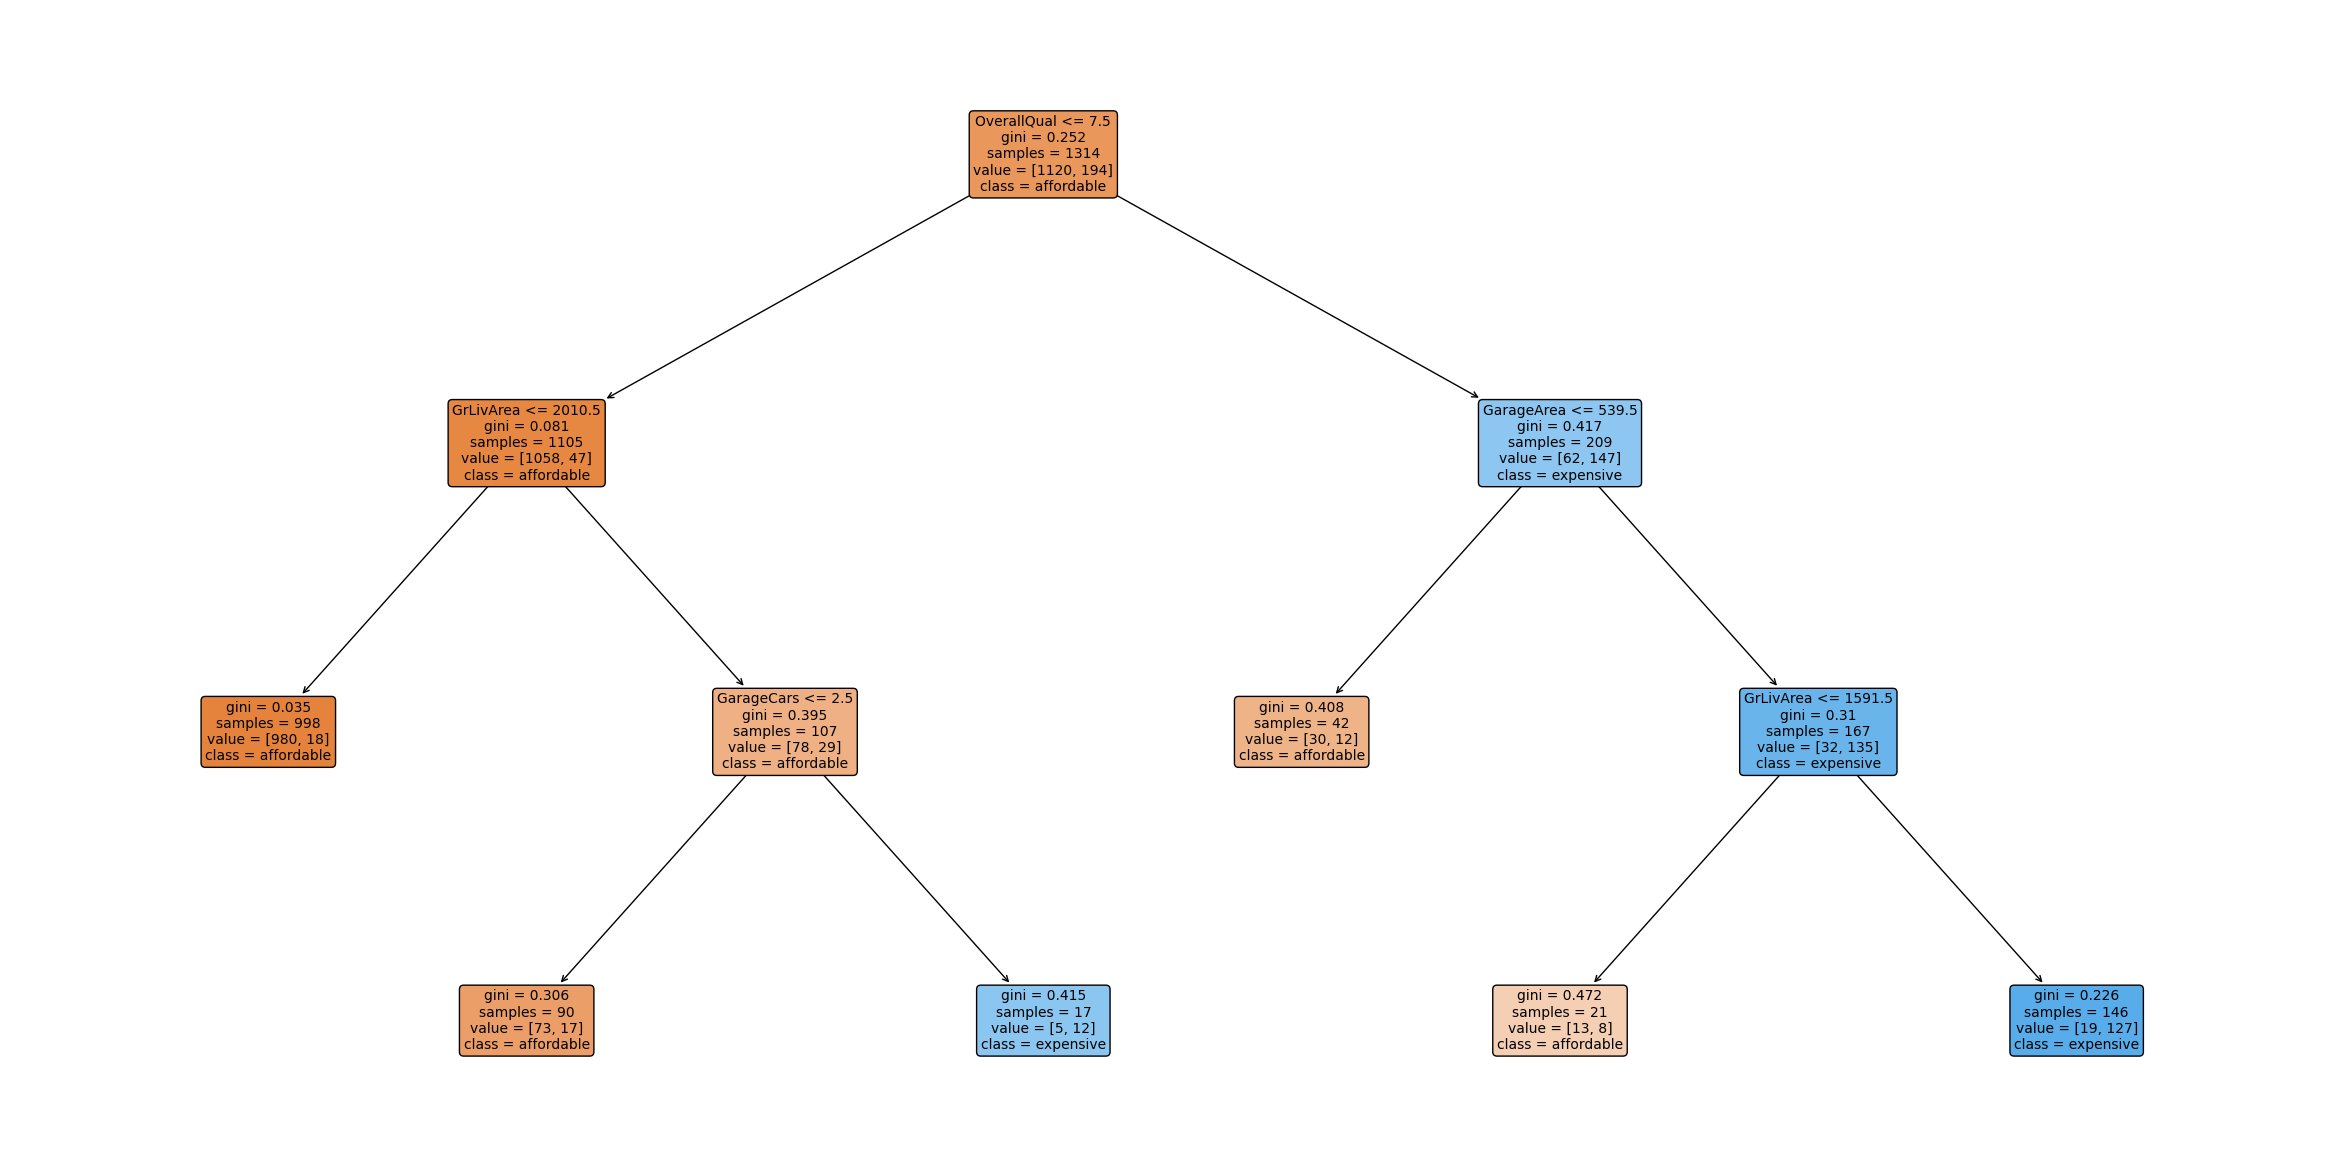

In [129]:
plt.figure(figsize=(30, 15))
plot_tree(search_tree.best_estimator_[1], feature_names=tree_columns, class_names=['affordable', 'expensive'], proportion=False and True, rounded=True, filled=True, fontsize=10);

### Scores

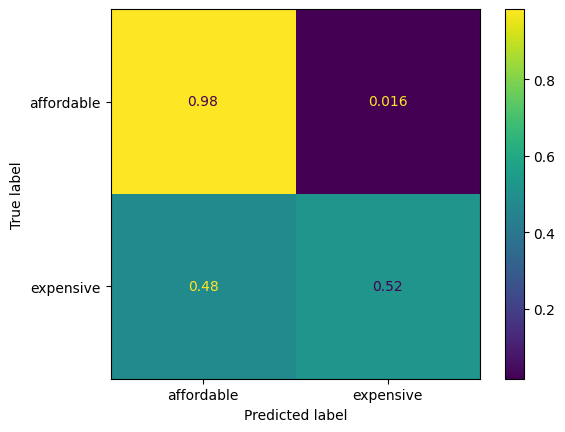

In [51]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_test,
    search_tree.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot()

On training set:

In [52]:
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

accuracy_score(
  y_pred=search_tree.predict(X_train),
  y_true=y_train)

0.9398782343987824

On test set:

In [53]:
result_scores['tree'] = (
  accuracy_score(
    y_pred=search_tree.predict(X_test),
    y_true=y_test),
  search_tree.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2})}

On complete set:

In [54]:
accuracy_score(
  y_pred=search_tree.predict(X),
  y_true=y)

0.936986301369863

### Final fit

In [55]:
final_tree = clone(search_tree.best_estimator_).fit(X, y)

In [56]:
(
  challenge_df
  .assign(Expensive = final_tree.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_9_final_tree.csv')

## Approach: Logistic

In [68]:
from sklearn.linear_model import LogisticRegressionCV

search_logistic = make_pipeline(
  preprocessor,
  scaler,
  LogisticRegressionCV(cv=5, n_jobs=-1, max_iter=100, scoring='accuracy', class_weight='balanced', solver='liblinear')
)

search_logistic.fit(X=X_train, y=y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinals',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(transformers=[('ExterQual',
                                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                                'Fa',
                                                                                                                                'TA',
                                                                                                                                'Gd',
                                                                                                                                'Ex']]),
                                                                                                    ['ExterQual']),
                                                                                                   ('ExterCond',
                                                                                                    OrdinalEncoder(categories=[['Po',
                                                                                                                                '...
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'KitchenAbvGr',
                                                   'TotRmsAbvGrd',
                                                   'GarageYrBlt', 'GarageArea', ...])])),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(class_weight='balanced', cv=5, n_jobs=-1,
                                      scoring='accuracy',
                                      solver='liblinear'))])

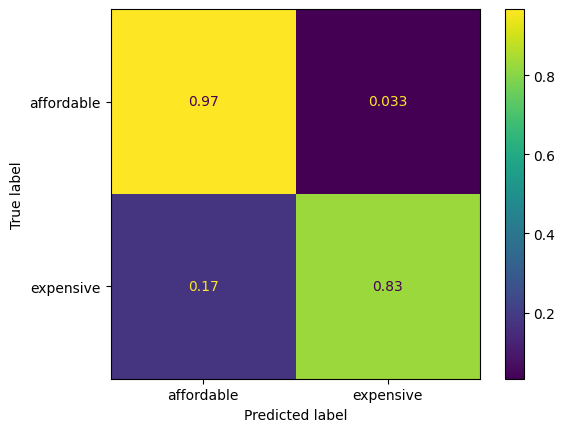

In [69]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_test,
    search_logistic.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

In [70]:
result_scores['logistic'] = (
accuracy_score(
  y_pred=search_logistic.predict(X_test),
  y_true=y_test),
  {}
)
result_scores


{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {})}

### Final fit

In [71]:
final_logistic = clone(search_logistic).fit(X, y)

In [72]:
(
  challenge_df
  .assign(Expensive = final_logistic.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_10_final_logistic.csv')

### Approach: Logistic with grid search

In [ ]:
from sklearn.linear_model import LogisticRegression

model_logistic_grid = LogisticRegression(max_iter=200, solver='liblinear')
pipe_logistic_grid = make_pipeline(preprocessor, scaler, model_logistic_grid)

grid_logistic = {
  'logisticregression__C': [1], #np.logspace(-4, 0, 4),
  'logisticregression__penalty': ['l2'], #['l1', 'l2', 'elasticnet'],
  'logisticregression__class_weight': ['balanced', None],
}

search_logistic_grid = GridSearchCV(
  pipe_logistic_grid,
  grid_logistic,
  cv=5,
  refit=True,
  scoring='accuracy',
  verbose=10,
  n_jobs=-1
)

search_logistic_grid.fit(X_train, y_train)

In [76]:
search_logistic_grid.best_score_

0.9452181232403565

In [77]:
search_logistic_grid.best_params_

{'logisticregression__C': 1,
 'logisticregression__class_weight': None,
 'logisticregression__penalty': 'l2'}

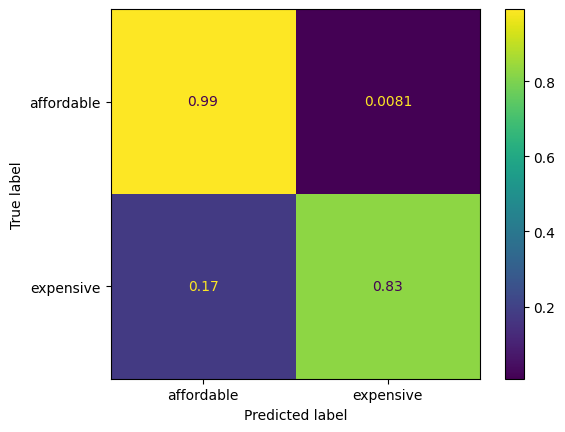

In [78]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_test,
    search_logistic_grid.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

In [79]:
result_scores['logistic_grid'] = (
  accuracy_score(
    y_pred=search_logistic_grid.predict(X_test),
    y_true=y_test),
  search_logistic_grid.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'})}

### Final fit

In [80]:
final_logistic_grid = clone(search_logistic_grid.best_estimator_).fit(X, y)

In [81]:
(
  challenge_df
  .assign(Expensive = final_logistic_grid.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_11_final_logistic_grid.csv')

## Approach: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier()# min_impurity_decrease=0.005)

pipe_forest = make_pipeline(preprocessor, model_forest)

roberto_grid_forest = {
  'randomforestclassifier__n_estimators': [50, 100, 200],
  'randomforestclassifier__max_depth': [None, 10, 20],
  'randomforestclassifier__min_samples_split': [2, 5, 10],
  'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

tv_grid_forest = {
  'randomforestclassifier__min_impurity_decrease': [0, 0.005], #[0.004, 0.005, 0.006], #[0, 0.005, 0.01, 0.05, 0.1],
  'randomforestclassifier__n_estimators': [15, 20, 30, 40], #, 200],
  'randomforestclassifier__max_depth': range(2, 15),
  'randomforestclassifier__min_samples_leaf': range(1, 6, 2),
  'randomforestclassifier__min_samples_split': range(2, 18, 5),
  'randomforestclassifier__class_weight': [None, 'balanced'], #, 'balanced_subsample', None],
}

tv_winning_param_grid={'randomforestclassifier__class_weight': [None],
            'randomforestclassifier__max_depth': range(2, 15),
            'randomforestclassifier__min_samples_leaf': range(3, 6, 2),
            'randomforestclassifier__min_samples_split': range(4, 20, 5),
            'randomforestclassifier__n_estimators': [10, 20, 100]}


grid_forest = tv_winning_param_grid

search_forest = GridSearchCV(
  pipe_forest,
  grid_forest,
  cv=5,
  refit=True,
  scoring='accuracy',
  verbose=10,
  n_jobs=-1
)

search_forest.fit(X_train, y_train)

In [112]:
search_forest.best_score_

0.952059327199373

In [113]:
search_forest.best_params_

{'randomforestclassifier__class_weight': None,
 'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__min_samples_split': 9,
 'randomforestclassifier__n_estimators': 20}

In [114]:
result_scores['forest'] = (
  accuracy_score(
    y_pred=search_forest.predict(X_test),
    y_true=y_test),
  search_forest.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'}),
 'forest': (0.958904109589041,
  {'randomforestclassifier__class_weight': None,
   'randomforestclassifier__max_depth': 14,
   'randomforestclassifier__min_samples_leaf': 5,
   'randomforestclassifier__min_samples_split': 9,
   'randomforestclassifier__n_estimators': 20}),
 'svc': (0.9315068493150684,
  {'svc__C': 1.0,
   'svc__class_weight': None,
   'svc__degree': 6,
   'svc__gamma': 'scale',
   'svc__kernel': 'poly'}),
 'nusvc': (0.9246575342465754,
  {'nusvc__class_weight': 'balanced',
   'nusvc__degree': 4,
   'nusvc__gamma': 'scale',
   'nusvc__kernel': 'pol

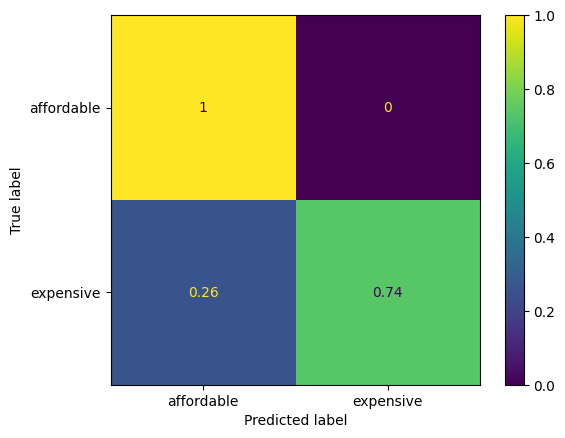

In [115]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_test,
    search_forest.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

### Retrain on full

In [116]:
final_forest = clone(search_forest.best_estimator_).fit(X, y)

In [117]:
(
  challenge_df
  .assign(Expensive = final_forest.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_12_final_forest.csv')

In [123]:
[ _.get_depth() for _ in final_forest[1].estimators_ ]

[14, 9, 12, 13, 13, 14, 8, 11, 10, 9, 11, 11, 9, 9, 10, 13, 11, 9, 10, 12]

In [148]:
final_forest_column_names = [ _[_.rfind('__')+2:] for _ in final_forest[1].feature_names_in_ ]

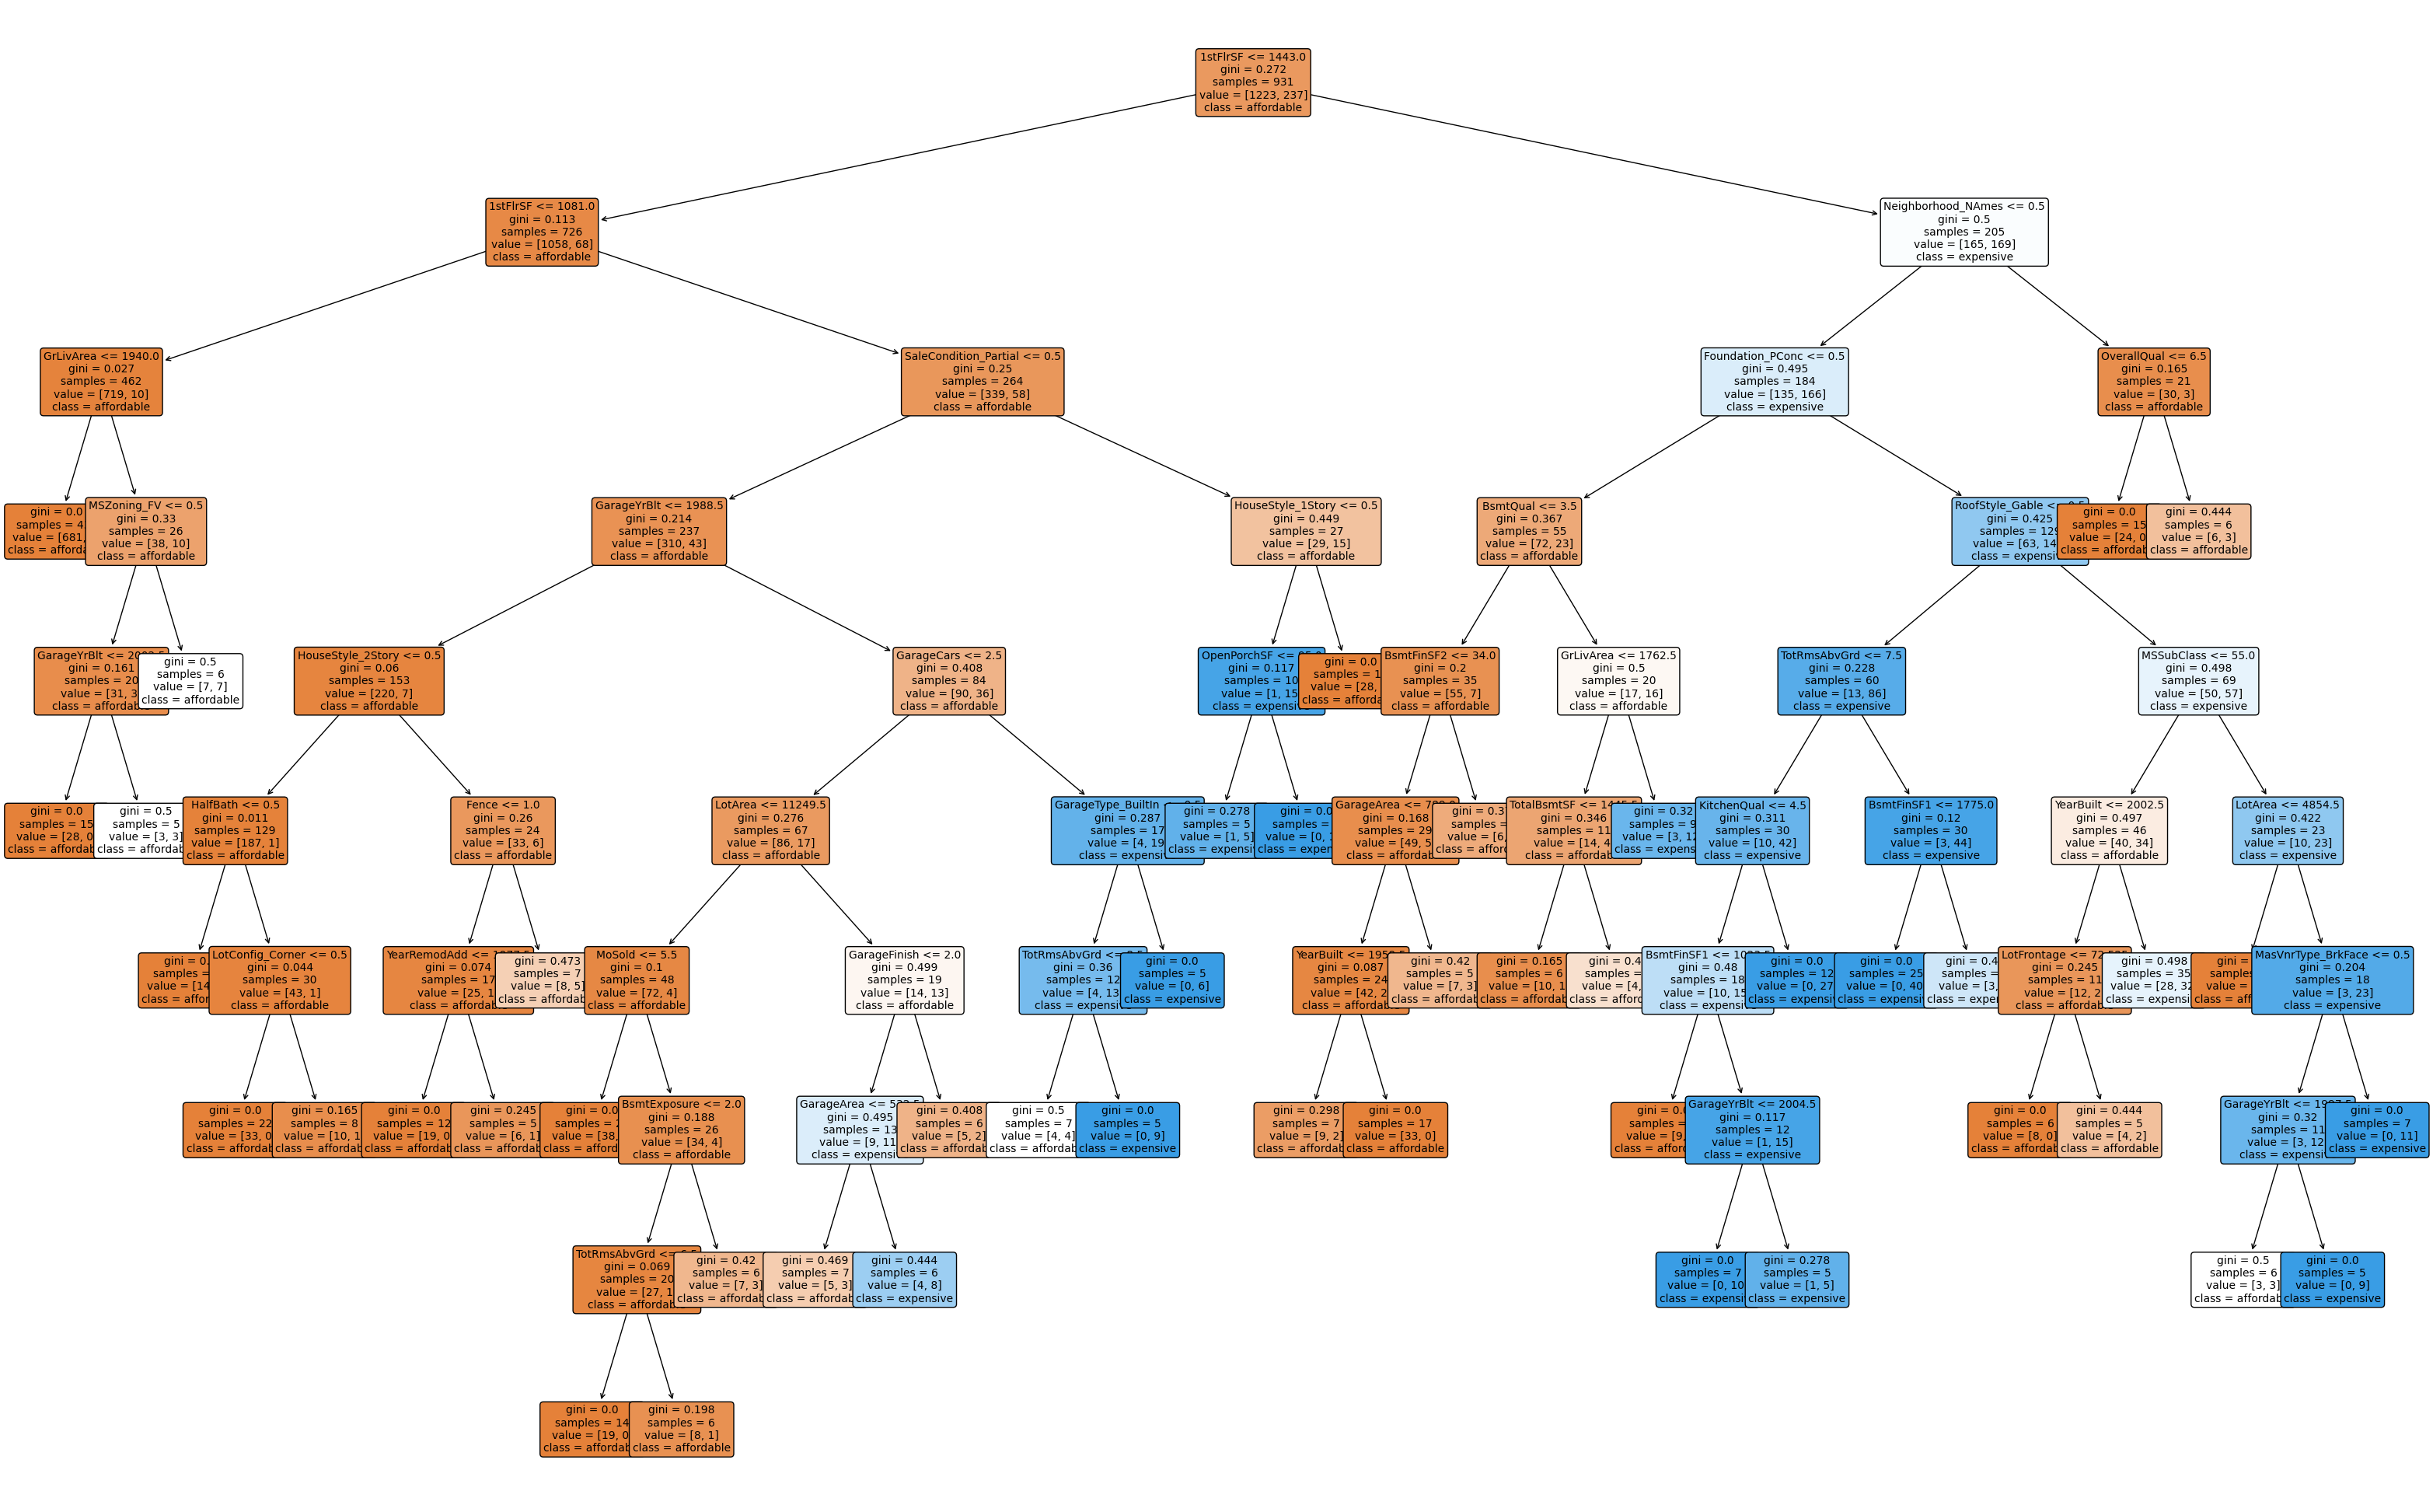

In [156]:
plt.figure(figsize=(40, 25))
plot_tree(final_forest[1].estimators_[9], feature_names=final_forest_column_names, class_names=['affordable', 'expensive'], proportion=False and True, rounded=True, filled=True, fontsize=10);

## Approach: SVC

In [ ]:
from sklearn.svm import SVC


model_svc = SVC()
pipe_svc = make_pipeline(preprocessor, scaler, model_svc)

grid_svc = {
  'svc__C': np.logspace(-4, 0, 4),
  'svc__kernel': ['poly'], #['linear', 'poly', 'rbf', 'sigmoid'],
  'svc__degree': range(4, 7),
  'svc__gamma': ['scale'],#, 'auto'], #np.logspace(-4, 0, 4),
  'svc__class_weight': ['balanced', None],
}

search_svc = GridSearchCV(
  pipe_svc,
  grid_svc,
  cv=5,
  refit=True,
  scoring='accuracy',
  verbose=10,
  n_jobs=-1
)

search_svc.fit(X_train, y_train)

In [90]:
search_svc.best_score_

0.953586044756625

In [91]:
search_svc.best_params_

{'svc__C': 1.0,
 'svc__class_weight': None,
 'svc__degree': 6,
 'svc__gamma': 'scale',
 'svc__kernel': 'poly'}

In [92]:
result_scores['svc'] = (
  accuracy_score(
    y_pred=search_svc.predict(X_test),
    y_true=y_test),
  search_svc.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'}),
 'forest': (0.9383561643835616,
  {'randomforestclassifier__class_weight': None,
   'randomforestclassifier__max_depth': 12,
   'randomforestclassifier__min_impurity_decrease': 0,
   'randomforestclassifier__min_samples_leaf': 1,
   'randomforestclassifier__min_samples_split': 2,
   'randomforestclassifier__n_estimators': 20}),
 'svc': (0.9315068493150684,
  {'svc__C': 1.0,
   'svc__class_weight': None,
   'svc__degree': 6,
   'svc__gamma': 'scale',
   'svc__kernel': 'poly'})}

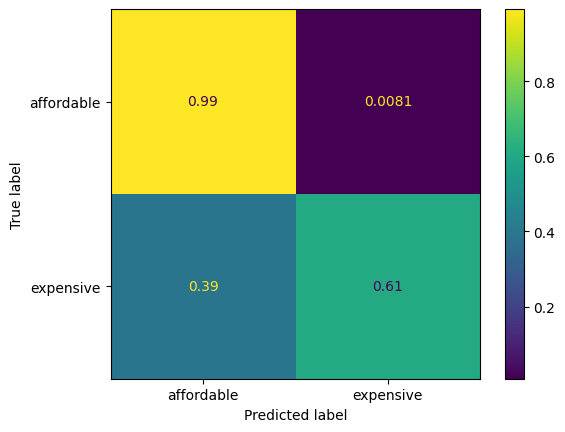

In [93]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_true = y_test,
    y_pred = search_svc.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

### Retrain on full

In [94]:
final_svc = clone(search_svc.best_estimator_).fit(X, y)

In [95]:
(
  challenge_df
  .assign(Expensive = final_svc.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_13_final_svc.csv')

## Approach: NuSVC

In [ ]:
from sklearn.svm import NuSVC

model_nusvc = NuSVC()
pipe_nusvc = make_pipeline(preprocessor, scaler, model_nusvc)

grid_nusvc = {
  'nusvc__nu': np.linspace(0.1, 0.9, 5),
  'nusvc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'nusvc__degree': range(4, 7),
  'nusvc__gamma': ['scale', 'auto'], #np.logspace(-4, 0, 4),
  'nusvc__class_weight': ['balanced', None],
}

search_nusvc = GridSearchCV(
  pipe_nusvc,
  grid_nusvc,
  cv=5,
  refit=True,
  scoring='accuracy',
  verbose=10,
  n_jobs=-1
)
search_nusvc.fit(X_train, y_train)


In [97]:
search_nusvc.best_score_

0.9505384146518445

In [98]:
search_nusvc.best_params_

{'nusvc__class_weight': 'balanced',
 'nusvc__degree': 4,
 'nusvc__gamma': 'scale',
 'nusvc__kernel': 'poly',
 'nusvc__nu': 0.1}

In [99]:
result_scores['nusvc'] = (
  accuracy_score(
    y_pred=search_nusvc.predict(X_test),
    y_true=y_test),
  search_nusvc.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'}),
 'forest': (0.9383561643835616,
  {'randomforestclassifier__class_weight': None,
   'randomforestclassifier__max_depth': 12,
   'randomforestclassifier__min_impurity_decrease': 0,
   'randomforestclassifier__min_samples_leaf': 1,
   'randomforestclassifier__min_samples_split': 2,
   'randomforestclassifier__n_estimators': 20}),
 'svc': (0.9315068493150684,
  {'svc__C': 1.0,
   'svc__class_weight': None,
   'svc__degree': 6,
   'svc__gamma': 'scale',
   'svc__kernel': 'poly'}),
 'nusvc': (0.9246575342465754,
  {'nusvc__class_weight': 'balanced',
   'nusvc__degree':

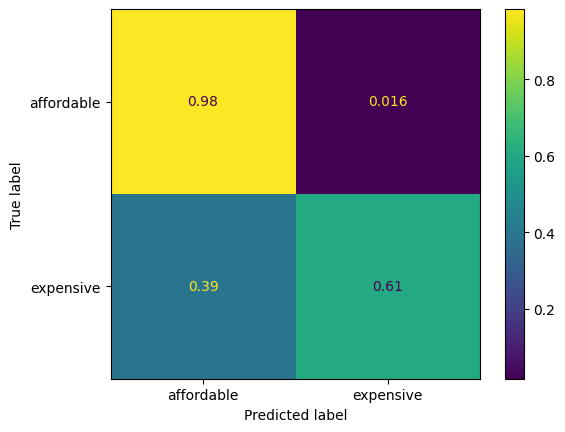

In [100]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_true = y_test,
    y_pred = search_nusvc.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

### Retrain on full

In [101]:
final_nusvc = clone(search_nusvc.best_estimator_).fit(X, y)

In [102]:
(
  challenge_df
  .assign(Expensive = final_nusvc.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_14_final_nusvc.csv')

## Approach: k-Nearest-Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
pipe_knn = make_pipeline(preprocessor, scaler, model_knn)

grid_knn = {
  'kneighborsclassifier__n_neighbors': range(3, 10, 2),
  'kneighborsclassifier__weights': ['uniform', 'distance'],
  'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
  'kneighborsclassifier__p': [1, 2],
}

search_knn = GridSearchCV(
  pipe_knn,
  grid_knn,
  cv=5,
  refit=True,
  scoring='accuracy',
  verbose=10,
  n_jobs=-1
)

search_knn.fit(X_train, y_train)

In [104]:
search_knn.best_score_

0.9345630278930717

In [105]:
search_knn.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

In [106]:
result_scores['knn'] = (
  accuracy_score(
    y_pred=search_knn.predict(X_test),
    y_true=y_test),
  search_knn.best_params_
)
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'}),
 'forest': (0.9383561643835616,
  {'randomforestclassifier__class_weight': None,
   'randomforestclassifier__max_depth': 12,
   'randomforestclassifier__min_impurity_decrease': 0,
   'randomforestclassifier__min_samples_leaf': 1,
   'randomforestclassifier__min_samples_split': 2,
   'randomforestclassifier__n_estimators': 20}),
 'svc': (0.9315068493150684,
  {'svc__C': 1.0,
   'svc__class_weight': None,
   'svc__degree': 6,
   'svc__gamma': 'scale',
   'svc__kernel': 'poly'}),
 'nusvc': (0.9246575342465754,
  {'nusvc__class_weight': 'balanced',
   'nusvc__degree':

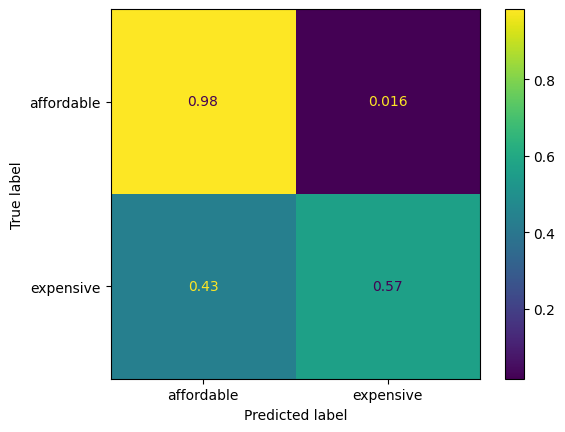

In [107]:
ConfusionMatrixDisplay(
  confusion_matrix(
    y_true = y_test,
    y_pred = search_knn.predict(X_test),
    normalize='true'
  ),
  display_labels=['affordable', 'expensive']
).plot();

### Retrain on full

In [108]:
final_knn = clone(search_knn.best_estimator_).fit(X, y)

In [109]:
(
  challenge_df
  .assign(Expensive = final_knn.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_15_final_knn.csv')

## Current best

In [457]:
(
  challenge_df
  .assign(Expensive = final_forest.predict(X=challenge_df))
  [['Expensive']]
).to_csv('../data/housing_iteration_6_competition/submission_8_forest_refit.csv')

In [110]:
result_scores

{'tree': (0.910958904109589,
  {'decisiontreeclassifier__max_depth': 3,
   'decisiontreeclassifier__min_impurity_decrease': 0.005,
   'decisiontreeclassifier__min_samples_leaf': 1,
   'decisiontreeclassifier__min_samples_split': 2}),
 'logistic': (0.9452054794520548, {}),
 'logistic_grid': (0.9657534246575342,
  {'logisticregression__C': 1,
   'logisticregression__class_weight': None,
   'logisticregression__penalty': 'l2'}),
 'forest': (0.9383561643835616,
  {'randomforestclassifier__class_weight': None,
   'randomforestclassifier__max_depth': 12,
   'randomforestclassifier__min_impurity_decrease': 0,
   'randomforestclassifier__min_samples_leaf': 1,
   'randomforestclassifier__min_samples_split': 2,
   'randomforestclassifier__n_estimators': 20}),
 'svc': (0.9315068493150684,
  {'svc__C': 1.0,
   'svc__class_weight': None,
   'svc__degree': 6,
   'svc__gamma': 'scale',
   'svc__kernel': 'poly'}),
 'nusvc': (0.9246575342465754,
  {'nusvc__class_weight': 'balanced',
   'nusvc__degree':